In [272]:
#Load the usual suspects

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [273]:
# Load the data

with np.load('/Users/David/Desktop/EPFL Applied ML/cifar4-train.npz', allow_pickle=False) as npz_file:
    pixels = npz_file['pixels'].astype('float32')
    overfeat = npz_file['overfeat']
    labels = npz_file['labels']
    names = npz_file['names']
    allow = npz_file['allow_pickle']
    
print('Pixels : {:}'.format(pixels.shape),
      'Overfeat: {:}'.format(overfeat.shape),
      'Labels: {:}'.format(labels.shape),
      'Names: {:}'.format(names.shape), 
      'Allow pickle: {:}'.format(allow.shape))

Pixels : (5000, 3072) Overfeat: (5000, 4096) Labels: (5000,) Names: (4,) Allow pickle: ()


In [274]:
# Rename the data and split into train (3200), test (1000) and validation (800) sets
X_ov = overfeat
X_px = pixels
y = labels

X_ov_tr, X_ov_te, X_px_tr, X_px_te, y_tr, y_te = train_test_split(X_ov, X_px, y, test_size=1000, stratify=y, random_state=0)
X_ov_tr, X_ov_val, X_px_tr, X_px_val, y_tr, y_val = train_test_split(X_ov_tr, X_px_tr, y_tr, test_size=800, stratify=y_tr, random_state=0)

# Double check dimensions for the overfeat data:
print('Train set: {:}'.format(X_ov_tr.shape), 'Test set: {:}'.format(X_ov_te.shape), 'Validation set: {:}'.format(X_ov_val.shape))

Train set: (3200, 4096) Test set: (1000, 4096) Validation set: (800, 4096)


In [275]:
#Create a knn pipeline with scaling and PCA preprocessing steps

knn_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step
    ('pca', PCA(n_components=176)), # pca step with 176 to get 90% of the proportion of variance explained
    ('knn', KNeighborsClassifier(n_jobs=-1)) # use all the computer cores for calculations
])

# Create a list with the iterable values to feed the knn model
k_values = np.arange(1, 21) # list of potential nearest neighbors 
weights = ['uniform', 'distance'] # added them for the sake of having an additional dimension
metric = [1, 2] # L1, L2 distances

# Create grid search object
knn_grid = ParameterGrid({
    'knn__n_neighbors' : k_values,
    'knn__weights' : weights,
    'knn__p' : metric
})

# Save accuracy on validation set
valid_scores = []

for i in knn_grid:
    # Set parameters
    knn_pipe.set_params(**i)

    # Fit the k-NN classifier
    knn_pipe.fit(X_ov_tr, y_tr)

    # Save accuracy on validation set
    i['accuracy'] = knn_pipe.score(X_ov_val, y_val)

    # Save validation results
    valid_scores.append(i)

In [276]:
# Put everything nicely into a dataframe and print the best validation accuracy
knn_df = pd.DataFrame(valid_scores)
knn_df.columns = ['accuracy', 'neighbors', 'metric', 'weight'] # column names
knn_df.replace({'metric': {1: 'L1', 2: 'L2'}}, inplace=True) # metric mapping

print('Top accuracy on validation set: {:.5f}'.format(knn_df['accuracy'].max()), 
      'with k: {:.0f}'.format(knn_df['neighbors'][knn_df['accuracy'].idxmax()]), 
      'and distance metric: {:}'.format(knn_df['metric'][knn_df['accuracy'].idxmax()]))

Top accuracy on validation set: 0.780000 with k: 18 and distance metric: L1


In [277]:
# Fit the knn classifier on the whole training set and calculate the accuracy on the test set

knn_pipe.set_params(knn__n_neighbors=knn_df['neighbors'][knn_df['accuracy'].idxmax()],
                   knn__weights=knn_df['weight'][knn_df['accuracy'].idxmax()],
                   knn__p=2).fit(X_ov_tr, y_tr)

print('k-NN accuracy (test set): {:.5f}'.format(knn_pipe.score(X_ov_te, y_te))) #obtained accuracy of 76.6%

k-NN accuracy (test set): 0.78100


In [280]:
# Plot the ten nearest neighbors of a randomly selected image

# Pass on the scaling and the PCA to the selected image using a pipeline:
pca_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step
    ('pca', PCA(n_components=176)) # pca step with components set to 176 to be consistent with the knn
])

knn_img = pca_pipe.fit_transform(X_px_te) # pass the pca_pipe to the full test set
img_selector = np.random.choice(np.arange(0, len(knn_img))) # Select a random image from the test set after transformation

# Reshape back to the input dimensions of the knn classifier, and identify the original image selected in pixels:
knn_img = knn_img[img_selector].reshape(1,-1)
original_img = X_px_te[img_selector]

# Identify the distances and the indeces of the 10 nearest neighbors from the training set, and add them to the original image:
nearest = knn_pipe.steps[2][1].kneighbors(knn_img, n_neighbors=10) # distances and indeces
images_set = np.vstack((original_img.reshape(1,-1), X_px_tr[nearest[1].reshape(10)])) # set of pixel images: original one + 10 neighbors obtained from slicing the training set by the indeces (nearest[1]). Needs a bit of reshaping to be dimensionally consistent.
distances = ['test image'] + ['d: {:.2f}'.format(i) for i in nearest[0].reshape(10)] # set of labels to be used for plotting. Includes the test image itself and the distances found in nearest[0]

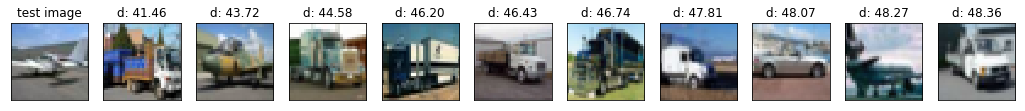

In [281]:
# Plot the test image + nearest 10 training neighbors randomly selected images

# Create figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(18, 8))

# Plot the 11 images
for i, axis in enumerate(axes.flatten()):
    # Get i-th image
    image = images_set[i]

    # Rescale pixel values between 0 and 1 for plotting, and reshape back to 32x32 pixels and RGB colours
    template = MinMaxScaler(feature_range=(0, 1)).fit_transform(image.reshape(-1, 1)).reshape(32, 32, 3)

    # Plot array with imshow()
    axis.imshow(template)
    axis.set_title(distances[i])
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show() #as expected by the classifier result the accuracy is around 78%, which means that 2 to 3 images should be wrongly classified